<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

**CONTESTO:** Rock o Hip-Hop? Applica metodi di machine learning per classificare i brani in generi musicali, senza doverli ascoltare :) 

**OBIETTIVO:** 

Utilizzando un set di dati composto da brani di due generi musicali (Hip-Hop e Rock), addestrerai un classificatore per distinguere tra i due generi in base solo alle informazioni sui brani derivate dai dati che hai a disposizione. Per prima cosa utilizzerai Pandas per analizzare i dati, aggregare informazioni e creare grafici con Seaborn o MatplotLib.

Successivamente, utilizzerai la libreria scikit-learn per prevedere se puoi classificare correttamente il genere di una canzone in base a caratteristiche come energia, acustica, tempo, ballabilità etc..


**Dati a disposizione:**

Qui puoi trovare due fonti dati, uno in formato csv e l'altro in formato json.

https://drive.google.com/drive/folders/1vPd0qBCpWm_QEXM5NRynNrs72-pUuhSn?usp=sharing

In [57]:
#Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics as met
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier

pd.set_option('display.max_rows', 2536)
pd.set_option('display.max_columns', 100)

In [58]:
# Loading of the dataset
df = pd.read_csv("./Dati/dataset.csv")
metrics = pd.read_json('./Dati/metrics.json', precise_float=True)

# Merge the dataframes
df_all = pd.merge(df[['track_id', 'genre_top']], metrics, on='track_id')

## Data cleaning

In [59]:
df_all.columns

Index(['track_id', 'genre_top', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence'],
      dtype='object')

Plot dei valori nulli

<Axes: >

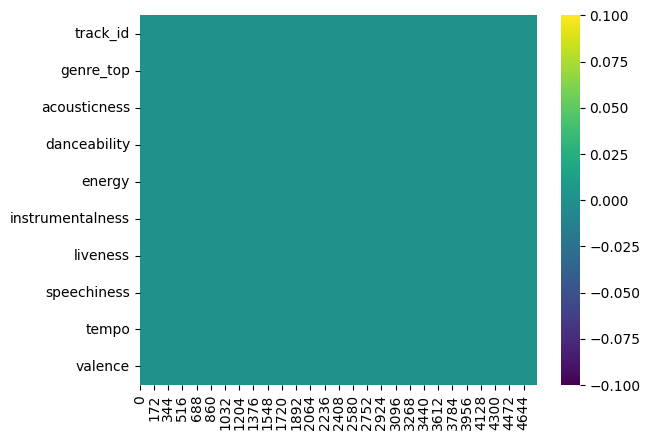

In [60]:
sns.heatmap(df_all.transpose().isnull(), cmap='viridis')

Analizzo le tipologie di dato

In [61]:
df_all.drop('track_id', inplace=True, axis=1)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genre_top         4802 non-null   object 
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
dtypes: float64(8), object(1)
memory usage: 504.2+ KB


## Exploratory data analysis

In [62]:
df_all.head()

,genre_top,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,Rock,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018
1,Rock,0.970135,0.352946,0.023852,0.957113,0.113261,0.032177,53.758,0.035632
2,Rock,0.981657,0.142249,0.912122,0.967294,0.363510,0.087527,91.912,0.034325
3,Rock,0.989141,0.225978,0.722835,0.263076,0.092371,0.053406,94.322,0.028347
4,Rock,0.886660,0.298518,0.744333,0.920950,0.139587,0.088781,97.880,0.073548


In [63]:
df_grouped = df_all.groupby('genre_top').mean().reset_index()
df_melted = pd.melt(df_grouped, id_vars='genre_top', value_vars=['acousticness', 'danceability', 'energy', 
                                                      'instrumentalness','liveness', 'speechiness', 
                                                      'tempo', 'valence'], var_name='feature', value_name='value')

<Axes: xlabel='feature', ylabel='value'>

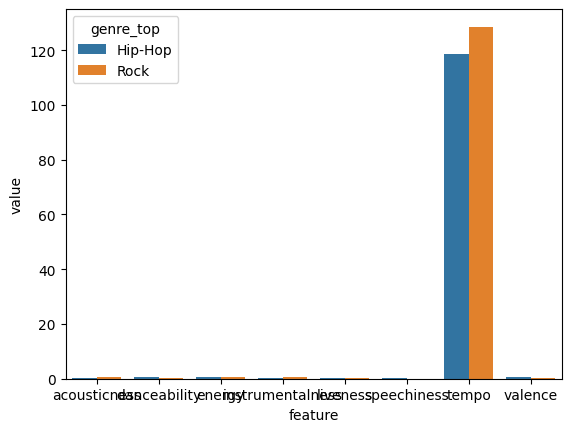

In [64]:
sns.barplot(x='feature', y='value', hue='genre_top', data=df_melted)

## Predictive model

Divisione dei dati d test e di train

In [80]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_all.loc[:, 'acousticness':], df_all.genre_top, test_size = 0.2, random_state=42)

Funzione che genera un dataframe a partire da un dizionario

In [81]:
# Ottengo un dataframe partendo dal dizionario
# con i valori dei test sulle performance del modello

def dict_to_df(dic):
    df = pd.DataFrame(columns=['type', 'function', 'depth', 'feature', 'value'])

    for f in dic.keys():
        for depth in dic[f].keys():
            for type in list(dic[f][depth].keys())[:2]:
                for feature in dic[f][depth][type].keys():
                    df.loc[len(df)] = [type, f, depth, feature, dic[f][depth][type][feature]]
            
    return df

In [82]:
# Faccio i test del modello con i diversi iper-parametri
# e salvo i risultati in un dizionario

results = {}

for f in ['entropy', 'gini', 'log_loss']:
    results[f] = dict()

    for depth in range(2, 20):
        tree = DecisionTreeClassifier(criterion=f, max_depth=depth, min_samples_split=2)
        tree = tree.fit(X_train, y_train)

        y_test_pred  = tree.predict(X_test)
        y_train_pred = tree.predict(X_train)

        results[f][depth] = met.classification_report(y_test, y_test_pred, output_dict=True)

In [83]:
#Ottengo il dataframe dal dizionario (con la funzione sopra)

new_df = dict_to_df(results)

new_df = new_df[new_df.feature == 'precision'].drop('feature', axis=1)


# Prendo in considerazione solo i dati sulla precision

new_df_g = new_df.groupby(['function', 'depth']).mean(numeric_only=True).reset_index()

# Prendo i parametri che hanno prodotto una precisione maggiore

s = new_df_g.iloc[new_df_g.loc[:, 'value'].idxmax(), :]
new_df[(new_df.function == s.function) & (new_df.depth == s.depth)]

,type,function,depth,value
32,Hip-Hop,entropy,6,0.785714
36,Rock,entropy,6,0.941992


### Model performance without scaling

In [84]:
# Faccio la predizione con i parametri migliori

tree = DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_split=2)
tree = tree.fit(X_train, y_train)

y_test_pred  = tree.predict(X_test)
y_train_pred = tree.predict(X_train)

Plot della matrice di confusione

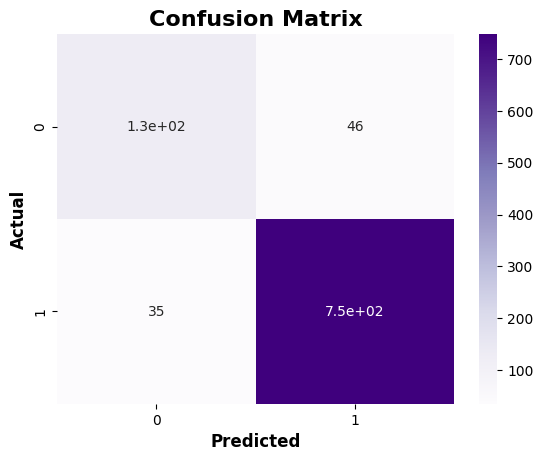

In [85]:
cf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Purples')
plt.title('Confusion Matrix', fontweight='bold', fontsize=16)
plt.xlabel('Predicted', fontweight='bold', fontsize=12)
plt.ylabel('Actual', fontweight='bold', fontsize=12)
plt.show();

Calcolo l'accuratezza del modello

In [86]:
print('Accuracy - Test Set: ',  met.accuracy_score(y_test, y_test_pred))
print('Accuracy - Train Set: ', met.accuracy_score(y_train, y_train_pred))

Accuracy - Test Set:  0.9157127991675338
Accuracy - Train Set:  0.9284040614423327


Ottengo metriche aggiuntive di valutazione

In [87]:
print('Report on test set \n', met.classification_report(y_test, y_test_pred))
print('Report on train set\n', met.classification_report(y_train, y_train_pred))

Report on test set 
               precision    recall  f1-score   support

     Hip-Hop       0.79      0.74      0.77       178
        Rock       0.94      0.96      0.95       783

    accuracy                           0.92       961
   macro avg       0.87      0.85      0.86       961
weighted avg       0.91      0.92      0.91       961

Report on train set
               precision    recall  f1-score   support

     Hip-Hop       0.81      0.81      0.81       732
        Rock       0.96      0.96      0.96      3109

    accuracy                           0.93      3841
   macro avg       0.88      0.88      0.88      3841
weighted avg       0.93      0.93      0.93      3841



### Model performance with scaling

Ora controllo se il modello con i dati scalati (con MinMaxScaler) performa meglio

In [88]:
from sklearn.preprocessing import MinMaxScaler

X_train = MinMaxScaler().fit_transform(X_train)
X_test  = MinMaxScaler().fit_transform(X_test)

In [89]:
# Faccio i test del modello con i diversi iper-parametri
# e salvo i risultati in un dizionario

results = {}

for f in ['entropy', 'gini', 'log_loss']:
    results[f] = dict()

    for depth in range(2, 20):
        tree = DecisionTreeClassifier(criterion=f, max_depth=depth, min_samples_split=2)
        tree = tree.fit(X_train, y_train)

        y_test_pred  = tree.predict(X_test)
        y_train_pred = tree.predict(X_train)

        results[f][depth] = met.classification_report(y_test, y_test_pred, output_dict=True)

In [90]:
#Ottengo il dataframe dal dizionario (con la funzione sopra)

new_df = dict_to_df(results)

new_df = new_df[new_df.feature == 'precision'].drop('feature', axis=1)


# Prendo in considerazione solo i dati sulla precision

new_df_g = new_df.groupby(['function', 'depth']).mean(numeric_only=True).reset_index()

# Prendo i parametri che hanno prodotto una precisione maggiore

s = new_df_g.iloc[new_df_g.loc[:, 'value'].idxmax(), :]
new_df[(new_df.function == s.function) & (new_df.depth == s.depth)]

,type,function,depth,value
304,Hip-Hop,log_loss,4,0.796296
308,Rock,log_loss,4,0.938673


In [91]:
# Effettuo la predizione

tree = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_split=2)
tree = tree.fit(X_train, y_train)

y_test_pred  = tree.predict(X_test)
y_train_pred = tree.predict(X_train)

Plot della matrice di confusione

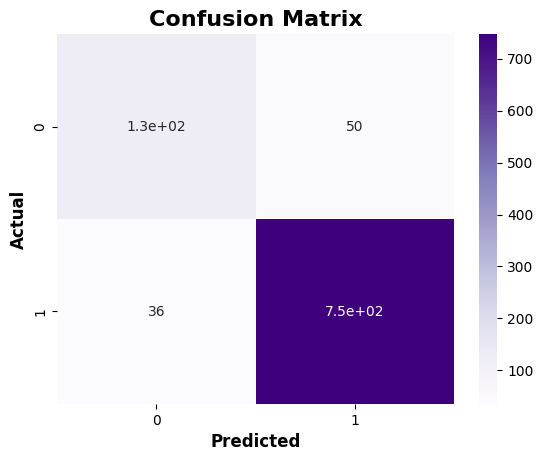

In [92]:
cf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Purples')
plt.title('Confusion Matrix', fontweight='bold', fontsize=16)
plt.xlabel('Predicted', fontweight='bold', fontsize=12)
plt.ylabel('Actual', fontweight='bold', fontsize=12)
plt.show();

Trovo i parametri migliori per il modello (come sopra)

In [93]:
print('Accuracy - Test Set: ',  met.accuracy_score(y_test, y_test_pred))
print('Accuracy - Train Set: ', met.accuracy_score(y_train, y_train_pred))

Accuracy - Test Set:  0.9105098855359001
Accuracy - Train Set:  0.9101796407185628


In [94]:
print('Report on test set \n', met.classification_report(y_test, y_test_pred))
print('Report on train set\n', met.classification_report(y_train, y_train_pred))

Report on test set 
               precision    recall  f1-score   support

     Hip-Hop       0.78      0.72      0.75       178
        Rock       0.94      0.95      0.95       783

    accuracy                           0.91       961
   macro avg       0.86      0.84      0.85       961
weighted avg       0.91      0.91      0.91       961

Report on train set
               precision    recall  f1-score   support

     Hip-Hop       0.80      0.71      0.75       732
        Rock       0.93      0.96      0.95      3109

    accuracy                           0.91      3841
   macro avg       0.86      0.83      0.85      3841
weighted avg       0.91      0.91      0.91      3841

